# Generative Adversarial Networks - GANs

![train_gan](plots/train_ganY.svg)

## Import necessary libraries and packages
---
First, we import all the packages and libraries needed to run the model. Notice we also import the MNIST dataset of handwritten digits directly from ```keras.datasets```.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from dataclasses import dataclass


## Defining Hyper-Parameters


In [2]:
@dataclass
class Config:
    """Configuration parameters for the GAN."""
    img_rows: int = 28
    img_cols: int = 28
    channels: int = 1
    img_shape: tuple = (28, 28, 1)
    z_dim: int = 100
    batch_size: int = 128
    learning_rate: float = 0.0002
    beta_1: float = 0.5
    epochs: int = 100

## Generator
---
In this notebook, and just for simplicity, the Generator is a neural network with only a single hidden layer. It takes in *z* as input and produces *28 x 28 x 1* image. In the hidden layer, *LeakyReLU* activation is used instead of *ReLU*, which allows a small positive gradients - avoiding vanishing gradient problem. At the output layer, *tanh* is applied, which scales the output values to the range [-1, 1]. The reason why *tanh* is used in this case, instead of e.g., *sigmoid* is that *tanh* tends to produce crispier image.

In [3]:
class Generator(tf.keras.Model):
    """Generator model to generate images from random noise."""

    def __init__(self, config):
        super(Generator, self).__init__()
        self.z_dim = config.z_dim
        self.img_shape = config.img_shape

        self.dense1 = Dense(128)
        self.leaky_relu = LeakyReLU(alpha=0.01)
        self.dense2 = Dense(np.prod(self.img_shape), activation='tanh')
        self.reshape = Reshape(self.img_shape)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.leaky_relu(x)
        x = self.dense2(x)
        x = self.reshape(x)
        return x

## Discriminator
---
The Discriminator takes in a *28 x 28 x 1* image and outputs a propability indicating whether the input is deemed real rather than fake. It is represented with a two-layer neural network, with *128* hidden units and a *Leaky ReLU* activation function at the hidden layer. Notice that unlike for the Generator, in the following listing the sigmoid activation function is applied at the Discriminator’s output layer. This ensures that the output value will be between 0 and 1, so it can be interpreted as the probability the Generator assigns that the input is real.

In [4]:
class Discriminator(tf.keras.Model):
    """Discriminator model to classify images as real or fake."""

    def __init__(self, config):
        super(Discriminator, self).__init__()
        self.img_shape = config.img_shape

        self.flatten = Flatten()
        self.dense1 = Dense(128)
        self.leaky_relu = LeakyReLU(alpha=0.01)
        self.dense2 = Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.dense1(x)
        x = self.leaky_relu(x)
        x = self.dense2(x)
        return x

## Load the Dataset

In [5]:
def load_dataset(config):
    """Loads and preprocesses the MNIST dataset."""
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train.astype('float32')
    X_train = X_train / 127.5 - 1.0  # Normalize to [-1, 1]
    X_train = np.expand_dims(X_train, axis=-1)
    buffer_size = X_train.shape[0]
    dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(config.batch_size)
    return dataset

## Training Loop
---
The following builds and compiles each of the Generator and Discriminator models implemented previously. In this implementation, the Discriminator parameters are set to be fixed during the Generator training. This implies that the the Generator only is training. In the ```train_step``` method, during the discriminator training, gradients are computed only with respect to the Discriminator's trainable variables: ```disc_tape.gradient(discriminator_loss, self.discriminator.trainable_variables)```. This means that, while the generator is involved in producing fake samples, it's weights don't get updated during this part of the process because the Generator's variables are not used in the optimizer's ```apply_gradient``` for the discriminator.

In [6]:
class GANTrainer:
    """Class to handle the training of the GAN."""

    def __init__(self, generator, discriminator, generator_optimizer, discriminator_optimizer, loss_fn, config):
        self.generator = generator
        self.discriminator = discriminator
        self.gen_optimizer = generator_optimizer
        self.disc_optimizer = discriminator_optimizer
        self.loss_fn = loss_fn
        self.z_dim = config.z_dim
        self.config = config

    @tf.function
    def train_step(self, real_images):
        """Performs a single training step."""
        current_batch_size = tf.shape(real_images)[0]

        # Generate noise for the generator
        noise = tf.random.normal([current_batch_size, self.z_dim])

        # Labels for real and fake images
        real_labels = tf.ones((current_batch_size, 1))
        fake_labels = tf.zeros((current_batch_size, 1))

        # Train discriminator
        with tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            real_loss = self.loss_fn(real_labels, real_output)
            fake_loss = self.loss_fn(fake_labels, fake_output)
            discriminator_loss = real_loss + fake_loss

        gradients_of_discriminator = disc_tape.gradient(discriminator_loss, self.discriminator.trainable_variables)
        self.disc_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        # Train generator
        noise = tf.random.normal([current_batch_size, self.z_dim])

        with tf.GradientTape() as gen_tape:
            generated_images = self.generator(noise, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            generator_loss = self.loss_fn(real_labels, fake_output)

        gradients_of_generator = gen_tape.gradient(generator_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

        return discriminator_loss, generator_loss

    def train(self, dataset, epochs=None, sample_interval=10):
        """Trains the GAN for a specified number of epochs."""
        if epochs is None:
            epochs = self.config.epochs

        for epoch in range(epochs):
            for image_batch in dataset:
                d_loss, g_loss = self.train_step(image_batch)

            # Print the progress
            print(f'Epoch {epoch+1}, D Loss: {d_loss.numpy()}, G Loss: {g_loss.numpy()}')

            # Generate and save images every few epochs
            if (epoch + 1) % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch, n=4):
        """Generates and displays a grid of generated images."""
        noise = tf.random.normal([n * n, self.z_dim])
        generated_images = self.generator(noise, training=False)    ################ HERE
        generated_images = (generated_images + 1) / 2.0  # Rescale to [0,1]

        fig, axes = plt.subplots(n, n, figsize=(4, 4))
        idx = 0
        for i in range(n):
            for j in range(n):
                axes[i, j].imshow(generated_images[idx, :, :, 0], cmap='gray')
                axes[i, j].axis('off')
                idx += 1
        plt.show()
        plt.close()

C:\Users\sulai\Documents\GH-Projects\GANs\env\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1, D Loss: 0.7340214848518372, G Loss: 0.9932557940483093
Epoch 2, D Loss: 1.0860337018966675, G Loss: 0.8499788045883179
Epoch 3, D Loss: 1.3744735717773438, G Loss: 0.9421007037162781
Epoch 4, D Loss: 1.2281758785247803, G Loss: 0.9749810099601746
Epoch 5, D Loss: 1.573777675628662, G Loss: 0.5622254014015198
Epoch 6, D Loss: 1.262374997138977, G Loss: 0.8103954195976257
Epoch 7, D Loss: 1.5586639642715454, G Loss: 0.7343488931655884
Epoch 8, D Loss: 1.3532203435897827, G Loss: 1.0184156894683838
Epoch 9, D Loss: 1.3006045818328857, G Loss: 0.8389231562614441
Epoch 10, D Loss: 1.286358118057251, G Loss: 0.8816856145858765


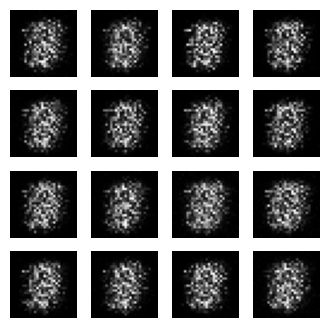

Epoch 11, D Loss: 1.2058131694793701, G Loss: 0.9706209897994995
Epoch 12, D Loss: 1.5390782356262207, G Loss: 0.813210666179657
Epoch 13, D Loss: 1.5276153087615967, G Loss: 0.7384178042411804
Epoch 14, D Loss: 1.3763563632965088, G Loss: 0.7018494606018066
Epoch 15, D Loss: 1.246604561805725, G Loss: 0.837242603302002
Epoch 16, D Loss: 1.15321683883667, G Loss: 1.0615074634552002
Epoch 17, D Loss: 1.2034552097320557, G Loss: 0.9055221080780029
Epoch 18, D Loss: 1.2842572927474976, G Loss: 0.9118868708610535
Epoch 19, D Loss: 0.9052321314811707, G Loss: 1.63699471950531
Epoch 20, D Loss: 0.747256338596344, G Loss: 1.6773279905319214


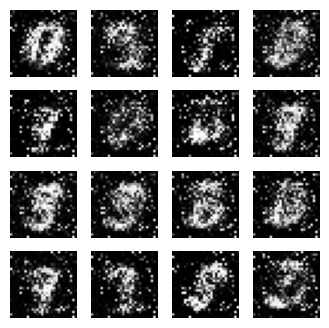

Epoch 21, D Loss: 1.1941571235656738, G Loss: 1.1922215223312378
Epoch 22, D Loss: 1.2060601711273193, G Loss: 1.012384295463562
Epoch 23, D Loss: 1.1336758136749268, G Loss: 1.0277559757232666
Epoch 24, D Loss: 1.0506103038787842, G Loss: 1.035954475402832
Epoch 25, D Loss: 1.3360626697540283, G Loss: 0.6547513008117676
Epoch 26, D Loss: 1.0960246324539185, G Loss: 1.0059006214141846
Epoch 27, D Loss: 1.2234326601028442, G Loss: 0.9100035429000854
Epoch 28, D Loss: 1.0834242105484009, G Loss: 0.9394256472587585
Epoch 29, D Loss: 1.191056489944458, G Loss: 0.7486996650695801
Epoch 30, D Loss: 1.1621408462524414, G Loss: 1.1615360975265503


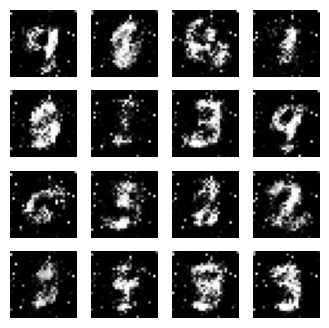

Epoch 31, D Loss: 0.962604284286499, G Loss: 1.389242172241211
Epoch 32, D Loss: 0.9020806550979614, G Loss: 1.9473116397857666
Epoch 33, D Loss: 0.8837980031967163, G Loss: 2.096686840057373
Epoch 34, D Loss: 1.1579208374023438, G Loss: 1.5855772495269775
Epoch 35, D Loss: 0.9973278045654297, G Loss: 1.1646034717559814
Epoch 36, D Loss: 1.1437768936157227, G Loss: 1.065445899963379
Epoch 37, D Loss: 1.2132599353790283, G Loss: 1.3881239891052246
Epoch 38, D Loss: 1.1596759557724, G Loss: 0.9923371076583862
Epoch 39, D Loss: 1.19010329246521, G Loss: 1.3348411321640015
Epoch 40, D Loss: 1.2281138896942139, G Loss: 1.2215242385864258


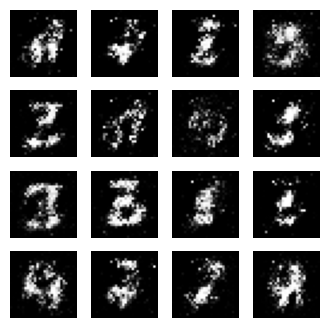

Epoch 41, D Loss: 1.29118812084198, G Loss: 0.92215895652771
Epoch 42, D Loss: 1.2543621063232422, G Loss: 1.182491660118103
Epoch 43, D Loss: 1.2357889413833618, G Loss: 1.4274318218231201
Epoch 44, D Loss: 1.1502492427825928, G Loss: 0.9214977025985718
Epoch 45, D Loss: 1.3413493633270264, G Loss: 1.3318127393722534
Epoch 46, D Loss: 1.240328073501587, G Loss: 1.0731773376464844
Epoch 47, D Loss: 1.1994929313659668, G Loss: 0.7263652086257935
Epoch 48, D Loss: 1.0865719318389893, G Loss: 1.0437102317810059
Epoch 49, D Loss: 1.123058795928955, G Loss: 0.8638453483581543
Epoch 50, D Loss: 1.336307406425476, G Loss: 0.8927483558654785


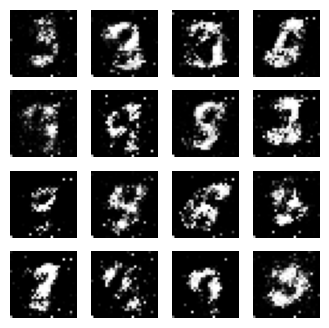

Epoch 51, D Loss: 1.2056834697723389, G Loss: 0.8147286176681519
Epoch 52, D Loss: 1.0995851755142212, G Loss: 0.9865924119949341
Epoch 53, D Loss: 1.0534827709197998, G Loss: 1.0736712217330933
Epoch 54, D Loss: 1.088627576828003, G Loss: 1.159014105796814
Epoch 55, D Loss: 1.1335017681121826, G Loss: 0.9806663990020752
Epoch 56, D Loss: 1.123343825340271, G Loss: 0.9314472079277039
Epoch 57, D Loss: 1.1020160913467407, G Loss: 0.9233781695365906
Epoch 58, D Loss: 1.1312994956970215, G Loss: 0.9224998354911804
Epoch 59, D Loss: 1.0284250974655151, G Loss: 1.3525896072387695
Epoch 60, D Loss: 1.015476107597351, G Loss: 1.2116246223449707


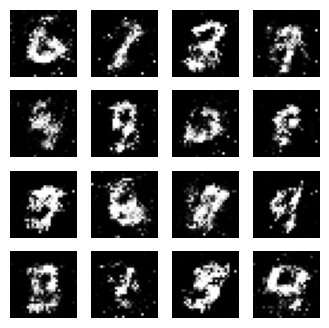

Epoch 61, D Loss: 1.1734694242477417, G Loss: 0.8548361659049988
Epoch 62, D Loss: 1.1226913928985596, G Loss: 0.9855895042419434
Epoch 63, D Loss: 1.0316829681396484, G Loss: 1.2841436862945557
Epoch 64, D Loss: 0.9871506690979004, G Loss: 1.1051361560821533
Epoch 65, D Loss: 1.2449136972427368, G Loss: 1.4707192182540894
Epoch 66, D Loss: 1.2205568552017212, G Loss: 0.939042329788208
Epoch 67, D Loss: 1.0857210159301758, G Loss: 1.144139051437378
Epoch 68, D Loss: 1.115920901298523, G Loss: 0.9638482928276062
Epoch 69, D Loss: 1.1456804275512695, G Loss: 1.2575531005859375
Epoch 70, D Loss: 1.1996469497680664, G Loss: 1.0656753778457642


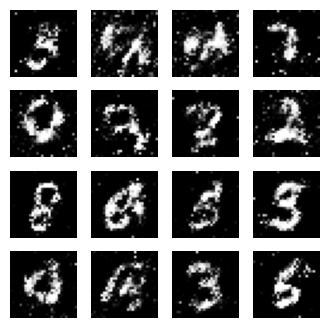

Epoch 71, D Loss: 1.1364737749099731, G Loss: 0.9346970319747925
Epoch 72, D Loss: 1.0279781818389893, G Loss: 1.3318153619766235
Epoch 73, D Loss: 1.087424874305725, G Loss: 1.364804983139038
Epoch 74, D Loss: 1.153451919555664, G Loss: 1.1278069019317627
Epoch 75, D Loss: 1.18337082862854, G Loss: 1.0783884525299072
Epoch 76, D Loss: 1.1058889627456665, G Loss: 0.9327497482299805
Epoch 77, D Loss: 1.1649147272109985, G Loss: 0.9554092288017273
Epoch 78, D Loss: 1.0987744331359863, G Loss: 0.7668554186820984
Epoch 79, D Loss: 1.233882188796997, G Loss: 1.2901968955993652
Epoch 80, D Loss: 1.1275233030319214, G Loss: 0.7510675191879272


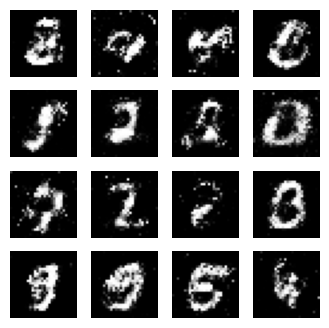

Epoch 81, D Loss: 1.2903773784637451, G Loss: 1.0767951011657715
Epoch 82, D Loss: 1.1805435419082642, G Loss: 1.2192577123641968
Epoch 83, D Loss: 1.1119091510772705, G Loss: 0.9257493019104004
Epoch 84, D Loss: 0.9788857102394104, G Loss: 1.290460467338562
Epoch 85, D Loss: 1.0346994400024414, G Loss: 0.8321685791015625
Epoch 86, D Loss: 1.110694169998169, G Loss: 1.3172000646591187
Epoch 87, D Loss: 1.0180584192276, G Loss: 1.1807823181152344
Epoch 88, D Loss: 0.962276816368103, G Loss: 1.0753378868103027
Epoch 89, D Loss: 1.1518136262893677, G Loss: 1.3584541082382202
Epoch 90, D Loss: 1.041587233543396, G Loss: 1.384273886680603


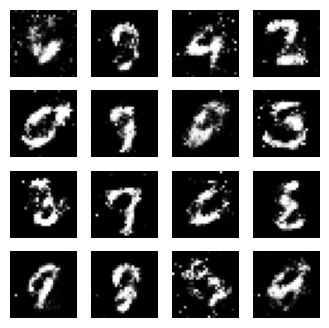

Epoch 91, D Loss: 0.9769732356071472, G Loss: 1.0018961429595947
Epoch 92, D Loss: 1.0226898193359375, G Loss: 0.974308967590332
Epoch 93, D Loss: 1.0475889444351196, G Loss: 0.8914262056350708
Epoch 94, D Loss: 1.0711051225662231, G Loss: 1.1739099025726318
Epoch 95, D Loss: 1.2144722938537598, G Loss: 0.9221076369285583
Epoch 96, D Loss: 1.0109241008758545, G Loss: 0.9684781432151794
Epoch 97, D Loss: 1.0514137744903564, G Loss: 0.9298137426376343
Epoch 98, D Loss: 1.0007717609405518, G Loss: 0.9962157011032104
Epoch 99, D Loss: 1.0894489288330078, G Loss: 0.9606623649597168
Epoch 100, D Loss: 1.1041408777236938, G Loss: 1.0497711896896362


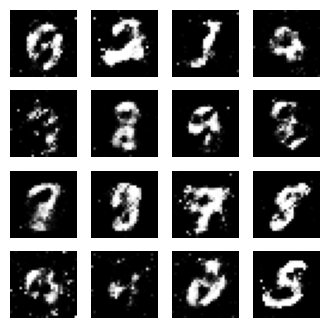

In [7]:
def main():
    """Main function to set up and train the GAN."""
    config = Config()

    # Instantiate models
    generator = Generator(config)
    discriminator = Discriminator(config)

    # Define optimizers and loss function
    generator_optimizer = Adam(learning_rate=config.learning_rate, beta_1=config.beta_1)
    discriminator_optimizer = Adam(learning_rate=config.learning_rate, beta_1=config.beta_1)
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    # Load dataset
    dataset = load_dataset(config)

    # Train the GAN
    trainer = GANTrainer(generator, discriminator, generator_optimizer, discriminator_optimizer, cross_entropy, config)
    trainer.train(dataset)


if __name__ == "__main__":
    main()